## Dataset: ISOT Dataset

[Dataset Link](https://onlineacademiccommunity.uvic.ca/isot/2022/11/27/fake-news-detection-datasets/)

1. Ahmed H, Traore I, Saad S. “Detecting opinion spams and fake news using text 
classification”, Journal of Security and Privacy, Volume 1, Issue 1, Wiley, 
January/February 2018.
2. Ahmed H, Traore I, Saad S. (2017) "Detection of Online Fake News Using N-Gram
Analysis and Machine Learning Techniques." In: Traore I., Woungang I., Awad A. (eds)
Intelligent, Secure, and Dependable Systems in Distributed and Cloud Environments. 
ISDDC 2017. Lecture Notes in Computer Science, vol 10618. Springer, Cham (pp. 127-138)

## Data Pre Processing

### Load Dataset

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install gensim
import nltk
nltk.download('punkt')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import seaborn as sns 
import gensim
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix

In [ ]:
real_news = pd.read_csv("isot/True.csv")
fake_news = pd.read_csv("isot/Fake.csv")

In [ ]:
# Combining both dataset into a single one
real_news['target']=1
fake_news['target']=0
df = pd.concat([real_news,fake_news]).reset_index(drop=True)

In [ ]:
# Combine title and text into a single column
df['original'] = df['title'] + ' ' + df['text']
df.head()

### Explore data

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
df.info()

Now we need to set the datatypes correct for date column

Some rows were not having proper dates.We replace them with top dates

In [ ]:
df['date'] = pd.to_datetime(df['date'],errors="coerce")
df["date"].fillna(df['date'].max(), inplace=True)

In [ ]:
df.head()

In [ ]:
df.info()

Visualising at what rates fake news has been recorded

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
df['date'].value_counts().plot(kind='line',ax=ax)
plt.title('Number of Articles by Date Fake news')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.show()

In [ ]:
df.isnull().sum()

No null values are observed. Dataset is pretty clean.
Some string entries were observed in date column in fake news dataset and were replaced with top date

Remove any unnecessary words (Stopwords) from the data provided

In [ ]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)
    return result

In [ ]:
# Transforming the non-matching subjects to the same notation
df.subject=df.subject.replace({'politics':'PoliticsNews','politicsNews':'PoliticsNews'})

Distribution of Subjects between the True and Fake News

In [ ]:
sub_tf_df=df.groupby('target').apply(lambda x:x['title'].count()).reset_index(name='Counts')
sub_tf_df.target.replace({0:'False',1:'True'},inplace=True)
fig = px.bar(sub_tf_df, x="target", y="Counts",
             color='Counts', barmode='group',
             height=400)
fig.show()

Dataset is balanced

Subjects that received the most news coverage

In [ ]:
sub_check=df.groupby('subject').apply(lambda x:x['title'].count()).reset_index(name='Counts')
fig=px.bar(sub_check,x='subject',y='Counts',color='Counts',title='Count of News Articles by Subject')
fig.show()

Using combination of title and content to make predictions

Applying stopword removal function here

In [ ]:
df['clean_final'] = df['original'].apply(preprocess)
df['clean_joined_final']=df['clean_final'].apply(lambda x:" ".join(x))

Wordcloud for real news

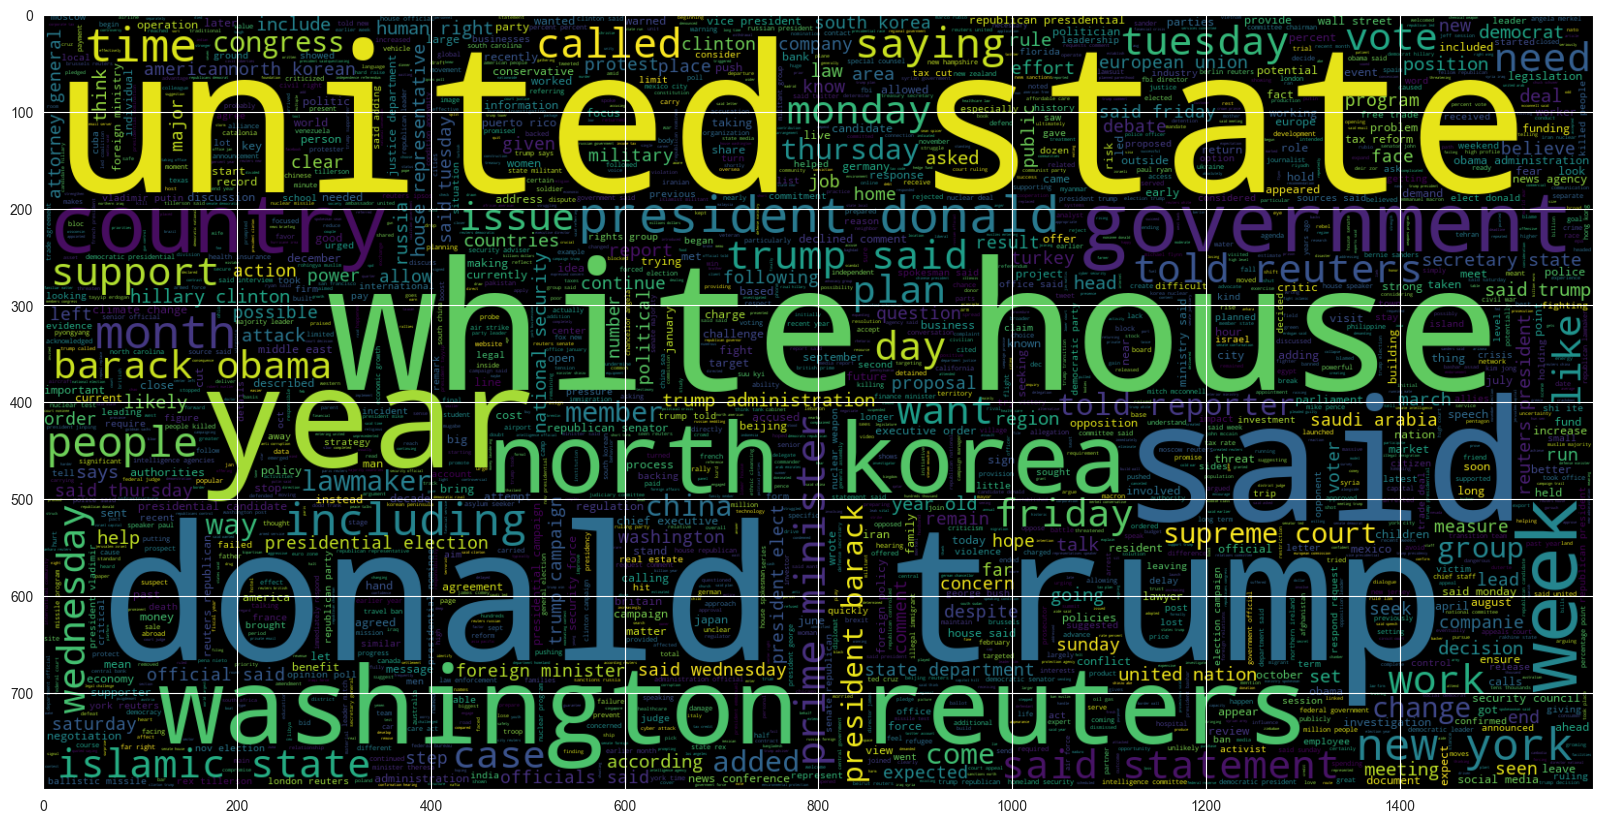

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 1].clean_joined_final))
plt.imshow(wc, interpolation = 'bilinear')

Wordcloud for fake news

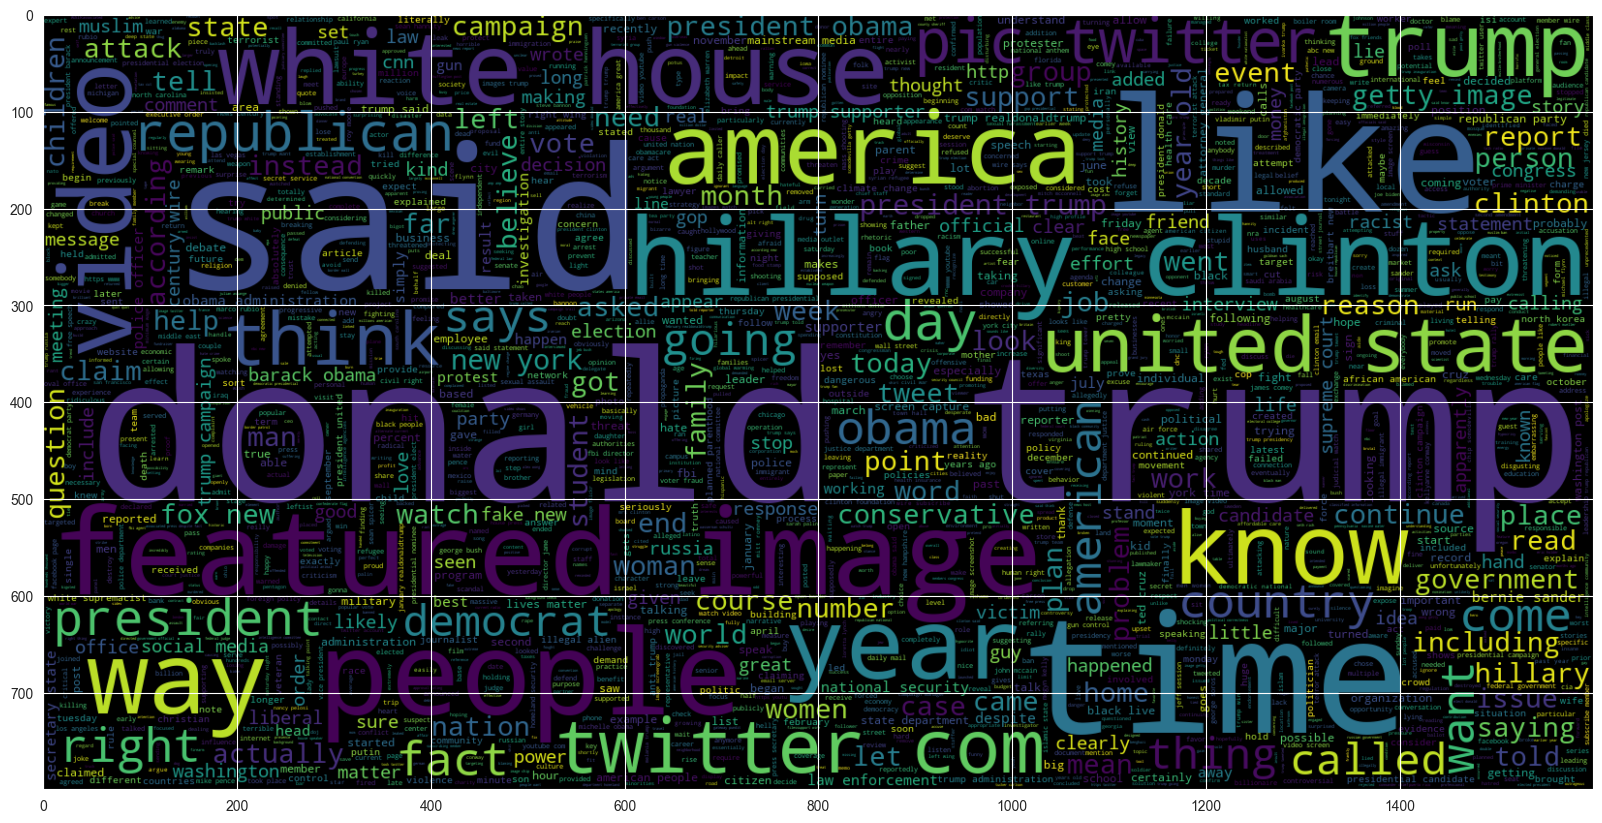

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 0].clean_joined_final))
plt.imshow(wc, interpolation = 'bilinear')

Identifying no of words in news content

In [ ]:
maxlen = -1
for doc in df.clean_joined_final:
    tokens = nltk.word_tokenize(doc)
    if maxlen<len(tokens):
        maxlen = len(tokens)
print("The maximum number of words in a News Content is =", maxlen)
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined_final], nbins = 50)
fig.show()

The maximum number of words in a News Content is = 4581


No of sentences in each content

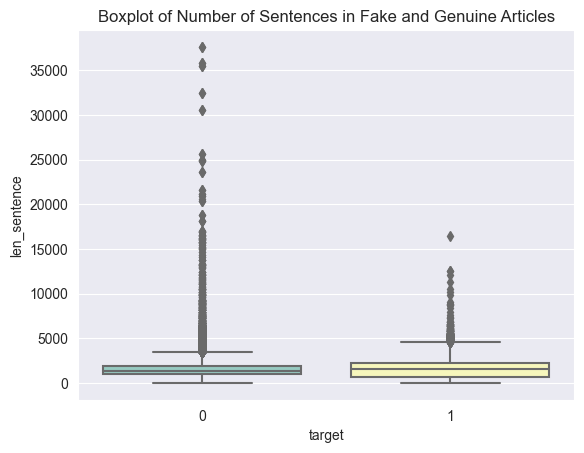

In [ ]:
df['len_sentence'] = df['clean_joined_final'].apply(len)
sns.boxplot(y='len_sentence', x='target', data=df, palette="Set3")
plt.title("Boxplot of Number of Sentences in Fake and Genuine Articles")
plt.show()

Length of sentences in fake news articles is high

Average No. of Words per Sentence Article


In [ ]:
from nltk import sent_tokenize
df['sent_tokens'] = df['clean_joined_final'].apply(sent_tokenize)

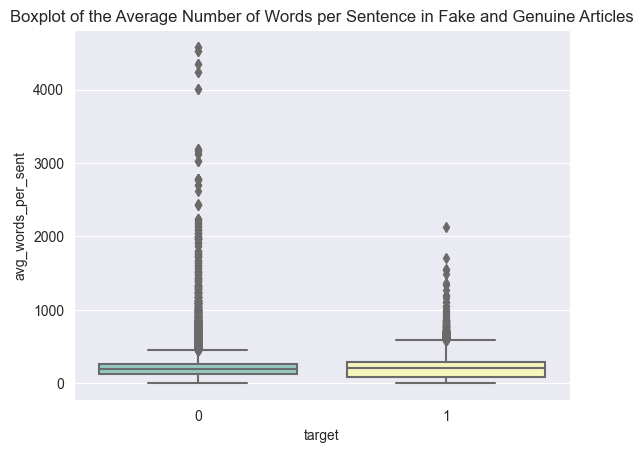

In [ ]:
import string
df['sent_word_tokens'] = df['sent_tokens'].apply(lambda x: [nltk.word_tokenize(each_sentence) for each_sentence in x])
def get_seq_tokens_cleaned(seq_tokens):
  no_punc_seq = [each_seq.translate(str.maketrans('', '', string.punctuation)) for each_seq in seq_tokens]
  sent_word_tokens = [nltk.word_tokenize(each_sentence) for each_sentence in no_punc_seq]
  return sent_word_tokens

df['sent_word_tokens'] = df['sent_tokens'].apply(lambda x: get_seq_tokens_cleaned(x))


def get_average_words_in_sent(seq_word_tokens):
  return np.mean([len(seq) for seq in seq_word_tokens])

df['avg_words_per_sent'] = df['sent_word_tokens'].apply(lambda x: get_average_words_in_sent(x))
sns.boxplot(y='avg_words_per_sent', x='target', data=df, palette="Set3")
plt.title("Boxplot of the Average Number of Words per Sentence in Fake and Genuine Articles")
plt.show()

Average Word Length per Article

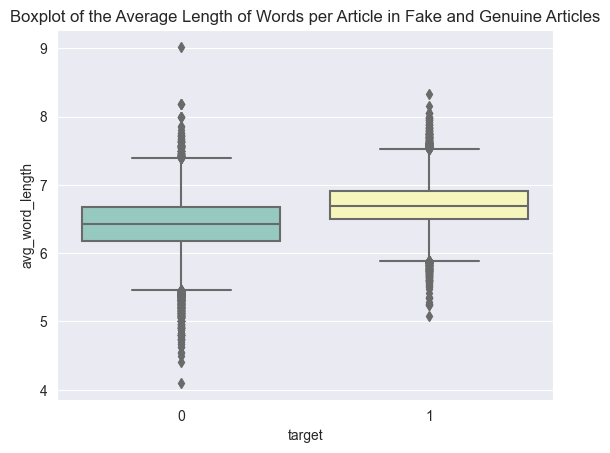

In [ ]:
def get_average_word_length(seq_word_tokens):
  return np.mean([len(word) for seq in seq_word_tokens for word in seq])

df['avg_word_length'] = df['sent_word_tokens'].apply(lambda x: get_average_word_length(x))

sns.boxplot(y='avg_word_length', x='target', data=df, palette="Set3")
plt.title("Boxplot of the Average Length of Words per Article in Fake and Genuine Articles")
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.clean_joined_final, df.target, test_size = 0.2,random_state=0)
vec_train = CountVectorizer().fit(X_train)
X_vec_train = vec_train.transform(X_train)
X_vec_test = vec_train.transform(X_test)

Training with different ML models

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [60]:
import time
df_perf_metrics = pd.DataFrame(columns=[
    'Model', 'Accuracy_Training_Set', 'Accuracy_Test_Set', 'Precision',
    'Recall', 'f1_score', 'Training Time (secs'
])
models_trained_list = []


def get_perf_metrics(model, i):
    # model name
    model_name = type(model).__name__
    # time keeping
    start_time = time.time()
    print("Training {} model...".format(model_name))
    # Fitting of model
    model.fit(X_vec_train, y_train)
    print("Completed {} model training.".format(model_name))
    elapsed_time = time.time() - start_time
    # Time Elapsed
    print("Time elapsed: {:.2f} s.".format(elapsed_time))
    # Predictions
    y_pred = model.predict(X_vec_test)
    # Add to ith row of dataframe - metrics
    df_perf_metrics.loc[i] = [
        model_name,
        model.score(X_vec_train, y_train),
        model.score(X_vec_test, y_test),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred), "{:.2f}".format(elapsed_time)
    ]
    # keep a track of trained models
    models_trained_list.append(model)
    print("Completed {} model's performance assessment.".format(model_name))
    prediction = []
    for i in range(len(y_pred)):
        if y_pred[i].item() > 0.5:
            prediction.append(1)
        else:
            prediction.append(0)
    cm = confusion_matrix(list(y_test), prediction)
    plt.figure(figsize = (2, 2))
    sns.heatmap(cm, annot = True,fmt='g',cmap='inferno')
    return model

Training LogisticRegression model...
Completed LogisticRegression model training.
Time elapsed: 5.26 s.
Completed LogisticRegression model's performance assessment.


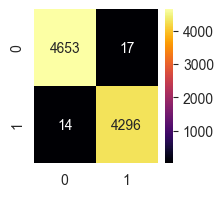

In [61]:
LogisticRegressionModel = get_perf_metrics(LogisticRegression(), 0)

Training MultinomialNB model...
Completed MultinomialNB model training.
Time elapsed: 0.04 s.
Completed MultinomialNB model's performance assessment.


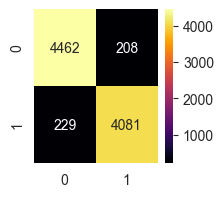

In [62]:
MultinomialNBModel = get_perf_metrics(MultinomialNB(), 1)

Training RandomForestClassifier model...
Completed RandomForestClassifier model training.
Time elapsed: 151.91 s.
Completed RandomForestClassifier model's performance assessment.


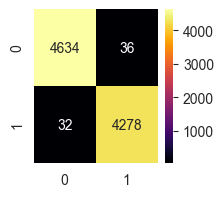

In [63]:
RandomForestClassifierModel = get_perf_metrics(RandomForestClassifier(), 2)

Training GradientBoostingClassifier model...
Completed GradientBoostingClassifier model training.
Time elapsed: 114.58 s.
Completed GradientBoostingClassifier model's performance assessment.


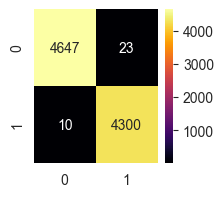

In [64]:
GradientBoostingClassifierModel = get_perf_metrics(GradientBoostingClassifier(), 3)

Training AdaBoostClassifier model...
Completed AdaBoostClassifier model training.
Time elapsed: 24.76 s.
Completed AdaBoostClassifier model's performance assessment.


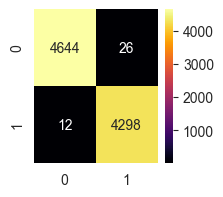

In [65]:
AdaBoostClassifierModel = get_perf_metrics(AdaBoostClassifier(), 4)

Training DecisionTreeClassifier model...
Completed DecisionTreeClassifier model training.
Time elapsed: 15.09 s.
Completed DecisionTreeClassifier model's performance assessment.


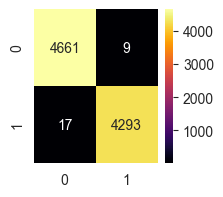

In [66]:
DecisionTreeClassifierModel = get_perf_metrics(DecisionTreeClassifier(),5)

Training SVC model...
Completed SVC model training.
Time elapsed: 1451.43 s.
Completed SVC model's performance assessment.


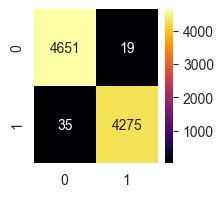

In [67]:
SVM_Model = get_perf_metrics(SVC(),6)

In [68]:
df_perf_metrics

Model  Accuracy_Training_Set  Accuracy_Test_Set  \
0          LogisticRegression               0.999972           0.996548   
1               MultinomialNB               0.957125           0.951336   
2      RandomForestClassifier               1.000000           0.992428   
3  GradientBoostingClassifier               0.996381           0.996325   
4          AdaBoostClassifier               0.995796           0.995768   
5      DecisionTreeClassifier               1.000000           0.997105   
6                         SVC               0.998691           0.993987   

   Precision    Recall  f1_score Training Time (secs  
0   0.996058  0.996752  0.996405                5.26  
1   0.951504  0.946868  0.949180                0.04  
2   0.991655  0.992575  0.992115              151.91  
3   0.994680  0.997680  0.996177              114.58  
4   0.993987  0.997216  0.995599               24.76  
5   0.997908  0.996056  0.996981               15.09  
6   0.995575  0.991879  0.993724             1451.43

Conclusions
Here Logistic regression is most desirable since it has high precision.The training time is also very less.

Testing with kaggle dataset

Data Pre processing

In [69]:
kaggle_df = pd.read_csv("data/train.csv")

In [70]:
kaggle_df.head()

id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print \nAn Iranian woman has been sentenced to...      1

In [71]:
kaggle_df = kaggle_df.drop('id',axis=1)
kaggle_df = kaggle_df.drop('author',axis=1)

In [72]:
kaggle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   20242 non-null  object
 1   text    20761 non-null  object
 2   label   20800 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 487.6+ KB


In [73]:
kaggle_df = kaggle_df.fillna(' ')
kaggle_df['clean_joined_final'] = kaggle_df['text'] + kaggle_df['title']
kaggle_df["target"] = kaggle_df["label"]

In [74]:
vec_train = CountVectorizer(max_features=104397).fit(kaggle_df.clean_joined_final)
kaggle_test = vec_train.transform(kaggle_df.clean_joined_final)

In [75]:
df_perf_metrics_kaggle = pd.DataFrame(columns=[
    'Model', 'Precision',
    'Recall', 'f1_score'
])

def get_perf_metrics_kaggle(model, i):
    model_name = type(model).__name__
    # Predictions
    y_pred_kaggle = model.predict(kaggle_test)
    prediction_kaggle = []
    for i in range(len(y_pred_kaggle)):
        if y_pred_kaggle[i].item() > 0.5:
            prediction_kaggle.append(1)
        else:
            prediction_kaggle.append(0)
    cm = confusion_matrix(list(kaggle_df.target), prediction_kaggle)
    plt.figure(figsize = (2, 2))
    sns.heatmap(cm, annot=True, fmt='g', cmap='inferno')

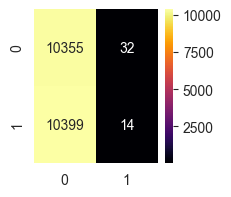

In [76]:
get_perf_metrics_kaggle(LogisticRegressionModel,0)

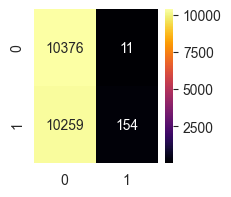

In [77]:
get_perf_metrics_kaggle(MultinomialNBModel,1)

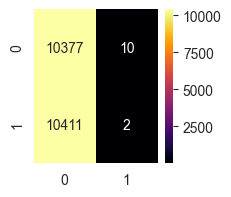

In [78]:
get_perf_metrics_kaggle(RandomForestClassifierModel,2)

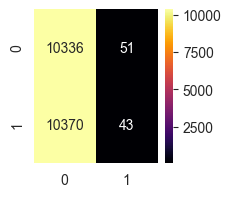

In [79]:
get_perf_metrics_kaggle(DecisionTreeClassifierModel,5)

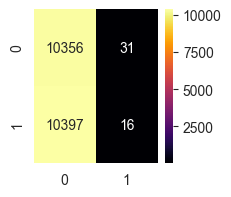

In [80]:
get_perf_metrics_kaggle(GradientBoostingClassifierModel,3)

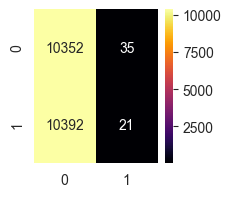

In [81]:
get_perf_metrics_kaggle(AdaBoostClassifierModel,4)

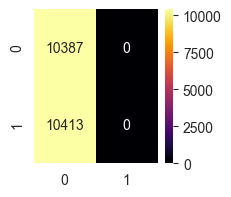

In [82]:
get_perf_metrics_kaggle(SVM_Model,6)

References:
1. https://onlineacademiccommunity.uvic.ca/isot/2022/11/27/fake-news-detection-datasets/
2. https://www.kaggle.com/code/paramarthasengupta/fake-news-detector-eda-prediction-99#Exploratory-Data-Analysis